# Imputación de datos

En lugar de eliminar los datos perdidos (o nulos) como vimos en el apartado anterior, que nos puede hacer perder gran parte de la información, podemos sustituirlos por valores que concuerden con el resto, facilitando así el aprendizaje posterior. A esta acción, en Ciencia de Datos, la llamamos imputar. Es un anglicismo de [*impute*](https://www.bennetyee.org/http_webster.cgi?isindex=impute&method=exact) y, aunque el significado exacto que le queremo dar [no se recoge en el diccionario de la RAE](https://dle.rae.es/imputar), éste sí es cercano en el sentido de atribuir. Vamos a atribuir valores adecuados a los huecos que tenemos en los datos.


## Métodos básicos

### Sustituir por la media

Vamos a ver como ejemplo un trozo del conjunto de datos usado en el apartado anterior con los valores anómalos marcados como nulos.

In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
dataset = datasets.fetch_openml(name='plasma_retinol', version=2, as_frame=True)
tabla = dataset.frame

umbral_z_score = 4.0

# Calcular z-score, marcando atípicos con np.nan
desc = tabla.describe()
for i, fila in tabla.iterrows():
    for caract in desc:
        z_score = abs(tabla.loc[i][caract] - desc.loc['mean'][caract]) / desc.loc['std'][caract]
        if z_score > umbral_z_score:
            tabla.loc[i,caract] = np.nan


tabla = tabla.iloc[256:263].copy()
tabla

,AGE,SEX,SMOKSTAT,QUETELET,VITUSE,CALORIES,FAT,FIBER,ALCOHOL,CHOLESTEROL,BETADIET,RETDIET,BETAPLASMA,binaryClass
256,40.0,Female,Never,31.24219,Yes_fairly_often,3014.9,165.7,14.4,0.0,NaN,1028.0,3061.0,0.0,P
257,29.0,Female,Never,37.93996,Yes_fairly_often,1631.0,55.6,13.8,0.5,189.5,3435.0,1104.0,84.0,N
258,71.0,Female,Former,24.98825,No,1399.5,66.5,9.6,8.0,260.0,1527.0,822.0,161.0,N
259,45.0,Female,Never,23.43164,Yes_fairly_often,2319.0,122.1,13.4,0.1,305.7,2047.0,1125.0,331.0,N
260,63.0,Female,Never,18.92094,No,1655.9,70.8,15.1,0.1,177.3,2897.0,505.0,366.0,P
261,46.0,Female,Former,24.26126,Yes_not_often,1422.8,58.3,7.8,7.1,206.3,1987.0,608.0,NaN,P
262,75.0,Female,Never,21.67837,Yes_fairly_often,2511.5,92.3,NaN,0.6,228.3,4271.0,916.0,NaN,P


In [2]:
tabla.fillna(tabla.mean())

,AGE,SEX,SMOKSTAT,QUETELET,VITUSE,CALORIES,FAT,FIBER,ALCOHOL,CHOLESTEROL,BETADIET,RETDIET,BETAPLASMA,binaryClass
256,40.0,Female,Never,31.24219,Yes_fairly_often,3014.9,165.7,14.40,0.0,227.85,1028.0,3061.0,0.0,P
257,29.0,Female,Never,37.93996,Yes_fairly_often,1631.0,55.6,13.80,0.5,189.50,3435.0,1104.0,84.0,N
258,71.0,Female,Former,24.98825,No,1399.5,66.5,9.60,8.0,260.00,1527.0,822.0,161.0,N
259,45.0,Female,Never,23.43164,Yes_fairly_often,2319.0,122.1,13.40,0.1,305.70,2047.0,1125.0,331.0,N
260,63.0,Female,Never,18.92094,No,1655.9,70.8,15.10,0.1,177.30,2897.0,505.0,366.0,P
261,46.0,Female,Former,24.26126,Yes_not_often,1422.8,58.3,7.80,7.1,206.30,1987.0,608.0,188.4,P
262,75.0,Female,Never,21.67837,Yes_fairly_often,2511.5,92.3,12.35,0.6,228.30,4271.0,916.0,188.4,P


### Interpolado

Cuando los datos son series temporales, es habitual que tengan cierta continuidad y reemplazar los valores perdidos por la media no es muy adecuado. En cambio, suele ser bastante más acertado realizar una interpolación con los valores anteriores y posteriores.

Vamos a usar como ejemplo un conjunto de datos que tiene una serie temporal de valores de análisis a lo largo del tiempo. Nos vamos a quedar sólo con los datos del primer gato para este ejemplo y le vamos a añadir unos valores perdidos para que veamos como de acertado es el interpolado en comparación con usar la media. Veamos la tabla original:

In [3]:
dataset = datasets.fetch_openml(name='newton_hema', version=2, as_frame=True)
tabla = dataset.frame
tabla = tabla[0:16].copy()
tabla

,id,weeks,cells_percentage,binaryClass
0,40004,11.0,33.0,N
1,40004,13.0,49.0,P
2,40004,19.0,46.0,P
3,40004,25.0,42.0,P
4,40004,28.0,68.0,P
5,40004,31.0,55.0,P
6,40004,33.0,38.0,P
7,40004,36.0,23.0,N
8,40004,41.0,32.0,N
9,40004,45.0,41.0,N


Y gráficamente: (El asignarla a la variable `_` es para ignorar lo que devuelve y evitar que Jupyter lo imprima. Es habitual usar el simbolo `_` para denotar una variable donde almacenamos algo que no vamos a usar.)

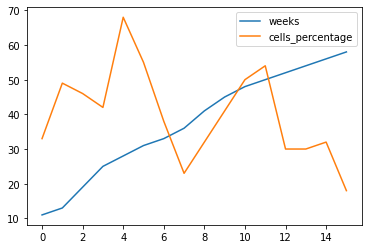

In [4]:
_ = tabla.plot()

Supongamos que estos valores se han perdido (veamos como queda la tabla y gráficamente representadas las series):

,id,weeks,cells_percentage,binaryClass
0,40004,11.0,33.0,N
1,40004,13.0,49.0,P
2,40004,NaN,46.0,P
3,40004,NaN,42.0,P
4,40004,28.0,68.0,P
5,40004,31.0,NaN,P
6,40004,33.0,38.0,P
7,40004,36.0,23.0,N
8,40004,41.0,NaN,N
9,40004,45.0,41.0,N


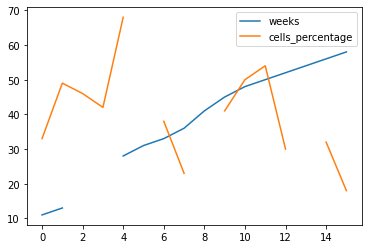

In [5]:
tabla.iloc[2:4,1] = np.nan
tabla.iloc[5,2] = np.nan
tabla.iloc[8,2] = np.nan
tabla.iloc[13,2] = np.nan
tabla.plot()
tabla

Si lo rellenasemos con la media saldría esto:

,id,weeks,cells_percentage,binaryClass
0,40004,11.000000,33.000000,N
1,40004,13.000000,49.000000,P
2,40004,39.714286,46.000000,P
3,40004,39.714286,42.000000,P
4,40004,28.000000,68.000000,P
5,40004,31.000000,40.307692,P
6,40004,33.000000,38.000000,P
7,40004,36.000000,23.000000,N
8,40004,41.000000,40.307692,N
9,40004,45.000000,41.000000,N


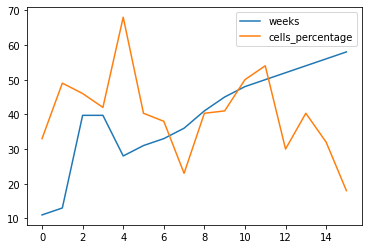

In [6]:
tabla_media = tabla.fillna(tabla.mean())
tabla_media.plot()
tabla_media

Si usamos el método [`interpolate()`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html#pandas.DataFrame.interpolate), podemos observar que el resultado es mucho más parecido al original. 

,id,weeks,cells_percentage,binaryClass
0,40004,11.0,33.0,N
1,40004,13.0,49.0,P
2,40004,18.0,46.0,P
3,40004,23.0,42.0,P
4,40004,28.0,68.0,P
5,40004,31.0,53.0,P
6,40004,33.0,38.0,P
7,40004,36.0,23.0,N
8,40004,41.0,32.0,N
9,40004,45.0,41.0,N


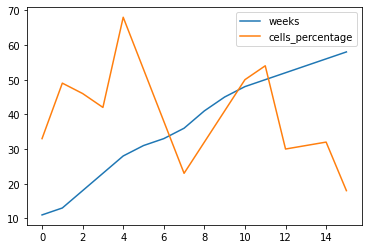

In [7]:
tabla_interpolada = tabla.copy()
tabla_interpolada['weeks'] = tabla['weeks'].interpolate()
tabla_interpolada['cells_percentage'] = tabla['cells_percentage'].interpolate()
tabla_interpolada.plot()
tabla_interpolada

**Ejercicio**: Encuentra un conjunto de datos que represente una serie temporal con datos perdidos y usa el método interpolate para sustituirlos.

En [Working with missing data (Pandas user guide)](https://pandas.pydata.org/pandas-docs/stable/user_guide/missing_data.html) hay mucha más información de como trabajar con valores perdidos en Pandas. Debes revisarla para conocer todas las posibilidades y, si pruebas algunos ejemplos de las cosas que no hemos cubierto, enriquecerás tu aprendizaje.

## Imputar valores perdidos con aprendizaje automático

Usar la media es una aproximación muy básica. Es mejor que dejar los valores perdidos a 0 u otros valores pero puede haber estrategias mejores. Hemos visto que, si los datos siguen una secuencia, la interpolación es más adecuada pero, cuando los datos no son series, la interpolación de los valores basandose en el anterior y posterior no tiene ningún sentido.

Una aproximación más avanzada, que puede resultar muy adecuada, es intentar predecir esos valores basandose en los valores de las demás características. Dado que las características suelen seguir unas relaciones entre ellas, podemos usar estas relaciones para rellenar los datos que faltan con un valor más apropiado que la media. Para ello, se puede utilizar cualquier algoritmo de aprendizaje de los que veréis en asignaturas posteriores. De momento, vamos a utilizar el KNN que [viene preparado para esto en *Scikit-learn*](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation).

En imputación de datos, las librerías Pandas y *Scikit-learn* se solapan cubriendo la imputación de datos (ambas tienen funcionalidades repetidas como sustituir por la media). Para este apartado, vamos a usar *Scikit-learn* porque es más completa. Hay mucha información sobre imputación de valores con *Scikit-learn* en el [apartado 6.4 de su manual de usuario](https://scikit-learn.org/stable/modules/impute.html#impute).

In [8]:
from sklearn.impute import KNNImputer

dataset = datasets.fetch_openml(name='sleep', version=2, as_frame=True)
tabla_sleep = dataset.frame
tabla_sleep

,body_weight,brain_weight,slow_wave,paradoxical,total_sleep,maximum_life_span,gestation_time,predation_index,sleep_exposure_index,overall_danger_index
0,6654.000,5712.0,NaN,NaN,3.3,38.6,645.0,3.0,5.0,3.0
1,1.000,6.6,6.3,2.0,8.3,4.5,42.0,3.0,1.0,3.0
2,3.385,44.5,NaN,NaN,12.5,14.0,60.0,1.0,1.0,1.0
3,0.920,5.7,NaN,NaN,16.5,NaN,25.0,5.0,2.0,3.0
4,2547.000,4603.0,2.1,1.8,3.9,69.0,624.0,3.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...
57,2.000,12.3,4.9,0.5,5.4,7.5,200.0,3.0,1.0,3.0
58,0.104,2.5,13.2,2.6,15.8,2.3,46.0,3.0,2.0,2.0
59,4.190,58.0,9.7,0.6,10.3,24.0,210.0,4.0,3.0,4.0
60,3.500,3.9,12.8,6.6,19.4,3.0,14.0,2.0,1.0,1.0


Si lo rellenasemos con la media, saldría esto:

In [9]:
tabla_sleep.fillna(tabla_sleep.mean())

,body_weight,brain_weight,slow_wave,paradoxical,total_sleep,maximum_life_span,gestation_time,predation_index,sleep_exposure_index,overall_danger_index
0,6654.000,5712.0,8.672917,1.972,3.300000,38.600000,645.0,3.0,5.0,3.0
1,1.000,6.6,6.300000,2.000,8.300000,4.500000,42.0,3.0,1.0,3.0
2,3.385,44.5,8.672917,1.972,12.500000,14.000000,60.0,1.0,1.0,1.0
3,0.920,5.7,8.672917,1.972,16.500000,19.877586,25.0,5.0,2.0,3.0
4,2547.000,4603.0,2.100000,1.800,3.900000,69.000000,624.0,3.0,5.0,4.0
...,...,...,...,...,...,...,...,...,...,...
57,2.000,12.3,4.900000,0.500,5.400000,7.500000,200.0,3.0,1.0,3.0
58,0.104,2.5,13.200000,2.600,15.800000,2.300000,46.0,3.0,2.0,2.0
59,4.190,58.0,9.700000,0.600,10.300000,24.000000,210.0,4.0,3.0,4.0
60,3.500,3.9,12.800000,6.600,19.400000,3.000000,14.0,2.0,1.0,1.0


Para rellenarlo usando el algoritmo de aprendizaje KNN podemos usar:

In [10]:
imputer = KNNImputer(n_neighbors=3, weights="uniform")
new_data = imputer.fit_transform(dataset.data)

Lo convertimos a Pandas para verlo bonito en tabla:

In [11]:
tabla_knn = pd.DataFrame(data=new_data, columns=dataset.feature_names)
tabla_knn

,body_weight,brain_weight,slow_wave,paradoxical,total_sleep,maximum_life_span,gestation_time,predation_index,sleep_exposure_index
0,6654.000,5712.0,3.433333,1.500000,3.3,38.600000,645.0,3.0,5.0
1,1.000,6.6,6.300000,2.000000,8.3,4.500000,42.0,3.0,1.0
2,3.385,44.5,7.700000,2.433333,12.5,14.000000,60.0,1.0,1.0
3,0.920,5.7,10.600000,2.666667,16.5,5.233333,25.0,5.0,2.0
4,2547.000,4603.0,2.100000,1.800000,3.9,69.000000,624.0,3.0,5.0
...,...,...,...,...,...,...,...,...,...
57,2.000,12.3,4.900000,0.500000,5.4,7.500000,200.0,3.0,1.0
58,0.104,2.5,13.200000,2.600000,15.8,2.300000,46.0,3.0,2.0
59,4.190,58.0,9.700000,0.600000,10.3,24.000000,210.0,4.0,3.0
60,3.500,3.9,12.800000,6.600000,19.4,3.000000,14.0,2.0,1.0


**Ejercicio**: Compara los valores obtenidos por los dos métodos y piensa cuales serán más útiles en el aprendizaje posterior. Razona tu respuesta por escrito. (Esto te servirá de práctica para el estudio que deberás realizar la próxima semana)

**Ejercicio**: Aplica `KNNImputer` a algún otro conjunto de datos con valores perdidos. Prueba a cambiar los parámetros y ver cómo varían los ajustes.

Para saber más sobre este tema y su utilidad, es interesante que veas la siguiente consulta y las respuestas que le han dado (ejemplo de algoritmo que necesita imputación de datos): https://www.researchgate.net/post/Is-it-possible-to-train-a-neural-network-with-missing-data

Avanzado (opcional y quizá mejor guardar para leer cuando ya hayais visto algoritmos de aprendizaje en otra asignatura). El siguiente artículo muestra ejemplo de un algoritmo que no necesita imputación de datos previa:
[Random forest missing data algorithms](https://onlinelibrary.wiley.com/doi/abs/10.1002/sam.11348?casa_token=E7iT0lTW-VIAAAAA%3AiFfdU3N8qjGqWZL4zLtkGnk40PF2Ud6qDKrEzAfS3i36vK-mZ_vwtSfSB__u7NQrygaFzxv9krpaA6S5ug)

    